# Composer Classification Deep Learning
#### AAI-511
#### University of San Diego
#### Kim Vierczhalek and Lishi Wang


The following notebook uses RNN and CNN models to identify the composer of a given piece of music. This notebook includes EDA on the midi files for four composers (Bach, Mozart, Chopin and Beethoven) as well as data preprocessing steps and Model architectures, training and results. Each section has headers to explain the intent of that particular section.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pretty_midi mido --quiet

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import PIL
import PIL.Image as Image
from IPython import display
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
import os
import pretty_midi
import librosa.display

from scipy import sparse
from scipy.sparse import csr_matrix

import pretty_midi
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from mido import KeySignatureError
import os
import random
import tensorflow as tf

### EDA
The following several sections of code preform EDA on the data files, this includes gathering labels, creating a piano roll, exploring quantity of files for each composer, exploring information about the data (pitch, tempo, velocity) and outputing the instrument distribution across all composers. This type of analysis is helpful in designing the model as well as identifying which preprocessing steps are needed in order to help the model acheive the highest level of accuracy possible.

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/AAI-511/Final_Project/dataset/'

In [ ]:
# Load data for CNN training
def process_midi_directory(directory):
    pr_list = []
    labels = []
    composers = os.listdir(directory)
    for composer in composers:
        composer_dir = os.path.join(directory, composer)
        if os.path.isdir(composer_dir):
            for filename in os.listdir(composer_dir):
                if filename.endswith('.mid') or filename.endswith('.midi'):
                    midi_path = os.path.join(composer_dir, filename)
                    midi_data = None
                    try:
                        midi_data = pretty_midi.PrettyMIDI(midi_path)
                    except:
                        print(midi_path)
                        continue
                    pr_list.append(midi_data)
                    labels.append(composer)
    return pr_list, labels

songs, labels = process_midi_directory(data_dir)

/content/drive/MyDrive/Colab Notebooks/AAI-511/Final_Project/dataset/Mozart/K281 Piano Sonata n03 3mov.mid


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


/content/drive/MyDrive/Colab Notebooks/AAI-511/Final_Project/dataset/Beethoven/Anhang 14-3.mid


In [ ]:
labels = np.array(labels)

unique, counts = np.unique(labels, return_counts=True)

# Print counts of each unique value
for value, count in zip(unique, counts):
    print(f"{value}  {count}")

Bach  925
Beethoven  212
Chopin  136
Mozart  256


### Collect Basic Info on each file
The following function processes the stats of each midi file. This is intended to be called within a loop or on individual files to collect stats on a variety of information, such as total number of tracks, length of notes, tempo changes and other information that might be useful in the data preprocessing stages later in the training section.

In [ ]:
def process_midi_dataset(dataset_path):
    """
    Process a dataset of MIDI files and aggregate the analysis results.

    Parameters:
        dataset_path (str): Path to the directory containing MIDI files.

    Returns:
        dict: Aggregated statistics and insights for the entire dataset.
    """
    # Initialize aggregation containers
    basic_stats = {
        'total_tracks': 0,
        'total_length_ticks': 0,
        'total_notes': 0,
        'unique_instruments': Counter()
    }
    note_distribution = Counter()
    rhythmic_patterns = {
        'average_note_durations': [],
        'tempo_changes': [],
        'time_signature_changes': Counter()
    }
    instrument_distribution = Counter()
    velocity_dynamics = {
        'average_velocities': [],
        'max_velocities': [],
        'min_velocities': [],
        'velocity_distribution': Counter()
    }

    # Iterate over each MIDI file in the dataset
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.mid'):
                midi_file_path = os.path.join(root, file)

                # Analyze basic statistics
                stats = analyze_basic_midi_statistics(midi_file_path)
                if stats is None:
                  continue


                basic_stats['total_tracks'] += stats['num_tracks']
                basic_stats['total_length_ticks'] += stats['total_length_ticks']
                basic_stats['total_notes'] += stats['total_notes']
                basic_stats['unique_instruments'].update([stats['unique_instruments']])

                # Analyze note distribution
                note_counts = analyze_note_distribution(midi_file_path)
                note_distribution.update(note_counts)

                # Analyze rhythmic patterns
                rhythm_analysis = analyze_rhythmic_patterns(midi_file_path)
                rhythmic_patterns['average_note_durations'].append(rhythm_analysis['average_note_duration'])
                rhythmic_patterns['tempo_changes'].extend(rhythm_analysis['tempo_changes'])
                rhythmic_patterns['time_signature_changes'].update(rhythm_analysis['time_signature_changes'])

                # Analyze instrument distribution
                instrument_counts = analyze_instrument_distribution(midi_file_path)
                instrument_distribution.update(instrument_counts)

                # Analyze velocity dynamics
                dynamics = analyze_velocity_dynamics(midi_file_path)
                velocity_dynamics['average_velocities'].append(dynamics['average_velocity'])
                velocity_dynamics['max_velocities'].append(dynamics['max_velocity'])
                velocity_dynamics['min_velocities'].append(dynamics['min_velocity'])
                velocity_dynamics['velocity_distribution'].update(dynamics['velocity_distribution'])

    # Aggregate results
    aggregated_results = {
        'basic_stats': {
            'total_tracks': basic_stats['total_tracks'],
            'total_length_ticks': basic_stats['total_length_ticks'],
            'total_notes': basic_stats['total_notes'],
            'unique_instruments_count': len(basic_stats['unique_instruments']),
            'average_instruments_per_file': np.mean(list(basic_stats['unique_instruments'].elements()))
        },
        'note_distribution': note_distribution,
        'rhythmic_patterns': {
            'average_note_duration': np.mean(rhythmic_patterns['average_note_durations']),
            'total_tempo_changes': len(rhythmic_patterns['tempo_changes']),
            'common_time_signatures': rhythmic_patterns['time_signature_changes'].most_common(3)
        },
        'instrument_distribution': instrument_distribution,
        'velocity_dynamics': {
            'average_velocity': np.mean(velocity_dynamics['average_velocities']) if velocity_dynamics['average_velocities'] else 0,  # Handle empty list
            'max_velocity': np.max(velocity_dynamics['max_velocities']) if velocity_dynamics['max_velocities'] else 0,  # Handle empty list
            'min_velocity': np.min(velocity_dynamics['min_velocities']) if velocity_dynamics['min_velocities'] else 0,  # Handle empty list
            'common_velocities': velocity_dynamics['velocity_distribution'].most_common(3)
        }
    }

    return aggregated_results

In [ ]:
# Iterate through all the files in each directory to gather and agregate basic stats
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        print(f"\n--- Analyzing {folder_name} ---")
        aggregated_results = process_midi_dataset(folder_path)
        print("Basic Statistics:")
        for key, value in aggregated_results['basic_stats'].items():
            print(f"  {key}: {value}")

# Iterate thorugh all the files in each directory to gather and aggregate Rythmic patterns
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        print(f"\n--- Analyzing {folder_name} ---")
        aggregated_results = process_midi_dataset(folder_path)
        print("Rhythmic Patterns:")
        print(f"  Average Note Duration: {aggregated_results['rhythmic_patterns']['average_note_duration']}")
        print(f"  Total Tempo Changes: {aggregated_results['rhythmic_patterns']['total_tempo_changes']}")
        print("  Common Time Signatures:")
        for signature, count in aggregated_results['rhythmic_patterns']['common_time_signatures']:
            print(f"    {signature}: {count}")

# Loop through all the files and gather velocity information
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        print(f"\n--- Analyzing {folder_name} ---")
        aggregated_results = process_midi_dataset(folder_path)
        print("Velocity Dynamics:")
        print(f"  Average Velocity: {aggregated_results['velocity_dynamics']['average_velocity']}")
        print(f"  Max Velocity: {aggregated_results['velocity_dynamics']['max_velocity']}")
        print(f"  Min Velocity: {aggregated_results['velocity_dynamics']['min_velocity']}")
        print("  Common Velocities:")
        for velocity, count in aggregated_results['velocity_dynamics']['common_velocities']:
            print(f"    {velocity}: {count}")

--- Analyzing Mozart ---
Error processing /content/drive/MyDrive/DataFiles/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Basic Statistics:
  total_tracks: 2843
  total_length_ticks: 102645.93818738835
  total_notes: 2406373
  unique_instruments_count: 15
  average_instruments_per_file: 6.48828125

--- Analyzing Beethoven ---
Error processing /content/drive/MyDrive/DataFiles/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Basic Statistics:
  total_tracks: 1904
  total_length_ticks: 107564.80470104773
  total_notes: 2710371
  unique_instruments_count: 15
  average_instruments_per_file: 5.502369668246446

--- Analyzing Chopin ---
Basic Statistics:
  total_tracks: 984
  total_length_ticks: 30084.67425522962
  total_notes: 577457
  unique_instruments_count: 8
  average_instruments_per_file: 1.75

--- Analyzing Bach ---
Basic Statistics:
  total_tracks: 6347
  total_length_ticks: 141267.42845187857
  total_notes: 2413465
  unique_instruments_count: 15
  average_instruments_per_file: 4.513513513513513

--- Analyzing Mozart ---
Error processing /content/drive/MyDrive/DataFiles/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Rhythmic Patterns:
  Average Note Duration: 154.16814529988562
  Total Tempo Changes: 50201
  Common Time Signatures:
    (0, (4, 4)): 107
    (0, (3, 4)): 66
    (0, (2, 4)): 41

--- Analyzing Beethoven ---
Error processing /content/drive/MyDrive/DataFiles/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Rhythmic Patterns:
  Average Note Duration: 151.941871306076
  Total Tempo Changes: 98209
  Common Time Signatures:
    (0, (4, 4)): 66
    (0, (3, 4)): 54
    (0, (2, 4)): 49

--- Analyzing Chopin ---
Rhythmic Patterns:
  Average Note Duration: 196.19499200958035
  Total Tempo Changes: 60078
  Common Time Signatures:
    (0, (4, 4)): 65
    (0, (3, 4)): 33
    (0, (6, 8)): 13

--- Analyzing Bach ---
Rhythmic Patterns:
  Average Note Duration: 588.0900457570657
  Total Tempo Changes: 17973
  Common Time Signatures:
    (0, (4, 4)): 603
    (0, (3, 4)): 133
    (0, (3, 8)): 32

--- Analyzing Mozart ---
Error processing /content/drive/MyDrive/DataFiles/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Velocity Dynamics:
  Average Velocity: 78.11665526582848
  Max Velocity: 127
  Min Velocity: 1
  Common Velocities:
    105: 149993
    80: 90865
    92: 67825

--- Analyzing Beethoven ---
Error processing /content/drive/MyDrive/DataFiles/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Velocity Dynamics:
  Average Velocity: 72.43653391720528
  Max Velocity: 127
  Min Velocity: 1
  Common Velocities:
    100: 122493
    127: 118553
    45: 52094

--- Analyzing Chopin ---
Velocity Dynamics:
  Average Velocity: 66.10959120036694
  Max Velocity: 127
  Min Velocity: 1
  Common Velocities:
    100: 16669
    60: 9703
    70: 7648

--- Analyzing Bach ---
Velocity Dynamics:
  Average Velocity: 91.55126380691169
  Max Velocity: 127
  Min Velocity: 1
  Common Velocities:
    96: 329827
    100: 225878
    76: 153365


### Visualizations
This section is part of the EDA, and includes visuals on the piano roll, distribution of the data, and instrument distribution.

<ipython-input-8-d90b55345213>:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(piano_roll[start_pitch:end_pitch],


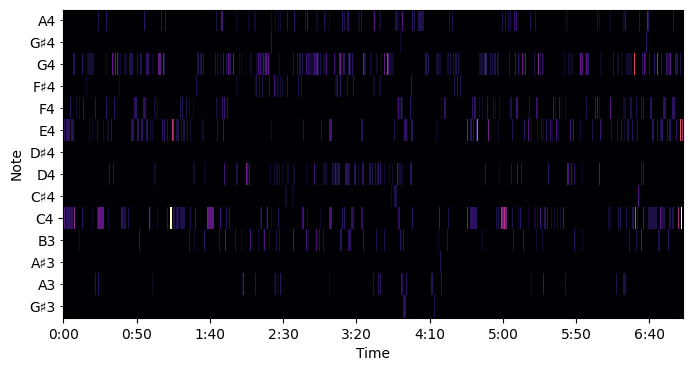

In [ ]:
def plot_piano_roll(piano_roll, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(piano_roll[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

example = songs[0].get_piano_roll(fs=100)
plt.figure(figsize=(8, 4))
plot_piano_roll(example, 56, 70)

## Preprocessing
The following section works on preprocessing the data and transforming any features or files that are going to skew the results. The RNN and CNN models have different shape and size requirements, so they are broken into two sections. The CNN preprocessing includes padding the data, converting the midi file into piano roll, and using LabelBinarizer to transform the data. The RNN preprocessing includes augmenting the data, padding, applying windowing and flattening for processing within the LSTM model. Both split the data into training and testing sets.

### CNN Preprocessing
Piano roll format takes a lot of memory. We will create a custom data pipeline that converts the pretty midi object to piano roll, pad and scale it at training time.

In [ ]:
encoder = OneHotEncoder(sparse=False)

labels = labels.reshape(-1, 1)

# Fit and transform
y = encoder.fit_transform(labels)
y = np.array(y, dtype='int')
print(y)

[[0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 ...
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
def preprocess_piano_roll(piano_roll, max_time_steps):
    # Pad the piano roll to the maximum length
    padded_roll = np.zeros((128, max_time_steps))
    num_time_steps = min(piano_roll.shape[1], max_time_steps)
    padded_roll[:128, :num_time_steps] = piano_roll[:128, :num_time_steps]
    scaled_roll = padded_roll.T / 127.0

    # Storing as sparse matrix to save memory
    piano_roll_sparse = csr_matrix(scaled_roll)
    return piano_roll_sparse

In [ ]:
class piano_roll_Generator(Sequence):
    def __init__(self, sparse_data, labels, batch_size):
        self.sparse_data = sparse_data
        self.labels = labels
        self.batch_size = batch_size
        self.num_samples = len(sparse_data)

    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min(start + self.batch_size, self.num_samples)

        batch_sparse = self.sparse_data[start:end]
        batch_dense = [s.toarray() for s in batch_sparse]  # Convert batch to dense
        batch_labels = self.labels[start:end]

        return np.array(batch_dense), np.array(batch_labels)

In [ ]:
print(len(songs))

1529


In [ ]:
X = []

for song in songs:
    piano_roll = song.get_piano_roll(fs=100)
    preprocessed_roll = preprocess_piano_roll(piano_roll, 5000)
    X.append(preprocessed_roll)

X = np.array(X)

In [ ]:
# Train test val split 60:20:20
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

In [ ]:
print(X_train[0].shape)

(5000, 128)


In [ ]:
train_generator = piano_roll_Generator(X_train, y_train, batch_size=8)
val_generator = piano_roll_Generator(X_val, y_val, batch_size=8)
test_generator = piano_roll_Generator(X_test, y_test, batch_size=8)

### RNN (LSTM)


In [ ]:
# Basic loading of midi data, extraction of different features
def load_midi_features(directory):
    """Loads MIDI files and extracts pitch, duration, and velocity features."""
    pitch_sequences = []
    duration_sequences = []
    velocity_sequences = []

    for filename in os.listdir(directory):
        if filename.endswith(".mid"):
            midi_path = os.path.join(directory, filename)
            try:
                midi = pretty_midi.PrettyMIDI(midi_path)
                for instrument in midi.instruments:
                    pitches = [note.pitch for note in instrument.notes]
                    durations = [note.end - note.start for note in instrument.notes]
                    velocities = [note.velocity for note in instrument.notes]
                    pitch_sequences.append(pitches)
                    duration_sequences.append(durations)
                    velocity_sequences.append(velocities)
            except KeySignatureError as e:
                print(f"Skipping file {filename} due to KeySignatureError: {e}")

    return pitch_sequences, duration_sequences, velocity_sequences

# Load features for each composer
bach_pitches, bach_durations, bach_velocities = load_midi_features("/content/drive/MyDrive/DataFiles/Bach/")
mozart_pitches, mozart_durations, mozart_velocities = load_midi_features("/content/drive/MyDrive/DataFiles/Mozart/")
beethoven_pitches, beethoven_durations, beethoven_velocities = load_midi_features("/content/drive/MyDrive/DataFiles/Beethoven/")
chopin_pitches, chopin_durations, chopin_velocities = load_midi_features("/content/drive/MyDrive/DataFiles/Chopin/")

# Normalize the data so one feature does not skew the output
def normalize_features(pitch_sequences, duration_sequences, velocity_sequences):
    """Normalizes pitches, durations, and velocities to a 0-1 range."""
    normalized_pitches = [[note / 127.0 for note in sequence] for sequence in pitch_sequences]
    max_duration = max([max(durations) for durations in duration_sequences if durations])
    normalized_durations = [[duration / max_duration for duration in sequence] for sequence in duration_sequences]
    normalized_velocities = [[velocity / 127.0 for velocity in sequence] for sequence in velocity_sequences]

    return normalized_pitches, normalized_durations, normalized_velocities

# Normalize the features
bach_pitches, bach_durations, bach_velocities = normalize_features(bach_pitches, bach_durations, bach_velocities)
mozart_pitches, mozart_durations, mozart_velocities = normalize_features(mozart_pitches, mozart_durations, mozart_velocities)
beethoven_pitches, beethoven_durations, beethoven_velocities = normalize_features(beethoven_pitches, beethoven_durations, beethoven_velocities)
chopin_pitches, chopin_durations, chopin_velocities = normalize_features(chopin_pitches, chopin_durations, chopin_velocities)


# Agument the data including sequence of notes and features
def augment_sequence(sequence, num_augmentations=2):
    """Augments a note sequence by transposing and creating variations."""
    augmented_sequences = [sequence]
    for _ in range(num_augmentations):
        transpose_amount = random.randint(-5, 5)  # Transpose by up to 5 semitones
        augmented_sequence = [[note[0] + transpose_amount, note[1], note[2]] for note in sequence] # Transpose only the pitch value (index 0)
        augmented_sequences.append(augmented_sequence)
    return augmented_sequences

def combine_features(pitch_sequences, duration_sequences, velocity_sequences):
    """Combines pitch, duration, and velocity features into a single array."""
    combined_features = []
    for pitches, durations, velocities in zip(pitch_sequences, duration_sequences, velocity_sequences):
        sequence_length = min(len(pitches), len(durations), len(velocities))
        combined_sequence = []
        for i in range(sequence_length):
            combined_sequence.append([pitches[i], durations[i], velocities[i]])
        combined_features.append(combined_sequence)
    return combined_features

# Combine features for each composer
combined_bach = combine_features(bach_pitches, bach_durations, bach_velocities)
combined_mozart = combine_features(mozart_pitches, mozart_durations, mozart_velocities)
combined_beethoven = combine_features(beethoven_pitches, beethoven_durations, beethoven_velocities)
combined_chopin = combine_features(chopin_pitches, chopin_durations, chopin_velocities)

# Augment combined data
augmented_combined_bach = [seq for orig_seq in combined_bach for seq in augment_sequence(orig_seq)]
augmented_combined_mozart = [seq for orig_seq in combined_mozart for seq in augment_sequence(orig_seq)]
augmented_combined_beethoven = [seq for orig_seq in combined_beethoven for seq in augment_sequence(orig_seq)]
augmented_combined_chopin = [seq for orig_seq in combined_chopin for seq in augment_sequence(orig_seq)]

def augment_with_noise(sequence, noise_factor=0.01):
    """Adds noise to the sequence to create variation."""
    noisy_sequence = []
    for note in sequence:
        noisy_note = [
            note[0] + random.uniform(-noise_factor, noise_factor),  # Pitch noise
            note[1] + random.uniform(-noise_factor, noise_factor),  # Duration noise
            note[2] + random.uniform(-noise_factor, noise_factor)   # Velocity noise
        ]
        noisy_sequence.append(noisy_note)
    return noisy_sequence

def augment_with_tempo(sequence, tempo_factor_range=(0.9, 1.1)):
    """Scales the tempo of the sequence."""
    tempo_factor = random.uniform(*tempo_factor_range)
    tempo_scaled_sequence = [[note[0], note[1] * tempo_factor, note[2]] for note in sequence]
    return tempo_scaled_sequence

# Augment with noise and tempo scaling
augmented_combined_bach.extend([augment_with_noise(seq) for seq in augmented_combined_bach])
augmented_combined_bach.extend([augment_with_tempo(seq) for seq in augmented_combined_bach])

augmented_combined_mozart.extend([augment_with_noise(seq) for seq in augmented_combined_mozart])
augmented_combined_mozart.extend([augment_with_tempo(seq) for seq in augmented_combined_mozart])

augmented_combined_beethoven.extend([augment_with_noise(seq) for seq in augmented_combined_beethoven])
augmented_combined_beethoven.extend([augment_with_tempo(seq) for seq in augmented_combined_beethoven])

augmented_combined_chopin.extend([augment_with_noise(seq) for seq in augmented_combined_chopin])
augmented_combined_chopin.extend([augment_with_tempo(seq) for seq in augmented_combined_chopin])


# Applying windowing to help the LSTM model sequentially process the data
def create_windows(sequence, window_size, step_size=1):
    """Splits a sequence into overlapping windows."""
    windows = []
    for start in range(0, len(sequence) - window_size + 1, step_size):
        end = start + window_size
        window = sequence[start:end]
        windows.append(window)
    return windows


# Apply windowing to all sequences
window_size = 50
step_size = 20

def apply_windowing(sequences, window_size, step_size=1):
    windowed_sequences = []
    for sequence in sequences:
        windows = create_windows(sequence, window_size, step_size)
        windowed_sequences.extend(windows)
    return windowed_sequences

# Apply windowing to each composer's dataset
windowed_bach = apply_windowing(augmented_combined_bach, window_size, step_size)
windowed_mozart = apply_windowing(augmented_combined_mozart, window_size, step_size)
windowed_beethoven = apply_windowing(augmented_combined_beethoven, window_size, step_size)
windowed_chopin = apply_windowing(augmented_combined_chopin, window_size, step_size)

# Combine windowed data
all_windowed_data = windowed_bach + windowed_mozart + windowed_beethoven + windowed_chopin

# Update labels for each windowed sequence
windowed_labels = [0] * len(windowed_bach) + [1] * len(windowed_mozart) + \
                  [2] * len(windowed_beethoven) + [3] * len(windowed_chopin)

# Flatten windowed data to extract unique pitches
flattened_data = [note[0] for sequence in all_windowed_data for note in sequence]

# Tokenize the note pitches
all_pitches = sorted(set(flattened_data))
note_to_int = {note: number for number, note in enumerate(all_pitches)}

# Convert note sequences to integer sequences
tokenized_data = [[note_to_int[note[0]] for note in sequence] for sequence in all_windowed_data]

# Pad sequences to ensure consistent input shape
X = pad_sequences(tokenized_data, maxlen=window_size, padding='post')

# Convert labels to one-hot encoding
labels = to_categorical(windowed_labels)

In [ ]:
# Split data into training and testing sets
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, labels, test_size=0.2, random_state=42)

## Model Construction
The following section defines the two different models as well as their training and results.

### CNN Model Training and Metrics


In [ ]:
CNNmodel = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(0.01),
                           input_shape=(5000, 128, 1)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
CNNmodel.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

CNNmodel.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 4998, 126, 32)       │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 4996, 124, 32)       │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 2498, 62, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 2496, 60, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2494, 58, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1247, 29, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1245, 27, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 1243, 25, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 621, 12, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 621, 12, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 953856)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │     244,187,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 244,507,748 (932.72 MB)

 Trainable params: 244,507,492 (932.72 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
history = CNNmodel.fit(train_generator, validation_data=val_generator, epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 98s 545ms/step - accuracy: 0.4823 - loss: 6.9931 - val_accuracy: 0.6503 - val_loss: 3.4440
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 31s 266ms/step - accuracy: 0.5945 - loss: 3.0826 - val_accuracy: 0.1209 - val_loss: 3.6605
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 31s 268ms/step - accuracy: 0.6703 - loss: 2.4209 - val_accuracy: 0.1601 - val_loss: 2.7397
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 31s 266ms/step - accuracy: 0.7096 - loss: 2.0217 - val_accuracy: 0.6503 - val_loss: 2.9826
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 31s 266ms/step - accuracy: 0.7949 - loss: 1.6616 - val_accuracy: 0.6503 - val_loss: 5.7123
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 31s 267ms/step - accuracy: 0.8539 - loss: 1.3360 - val_accuracy: 0.6242 - val_loss: 2.4309
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 31s 266ms/step - accuracy: 0.8949 - loss: 1.1734 - val_accuracy: 0.6732 - val_loss: 3.6693
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 31s 266ms/step - accuracy: 0.9176 - loss: 0.9389 - val

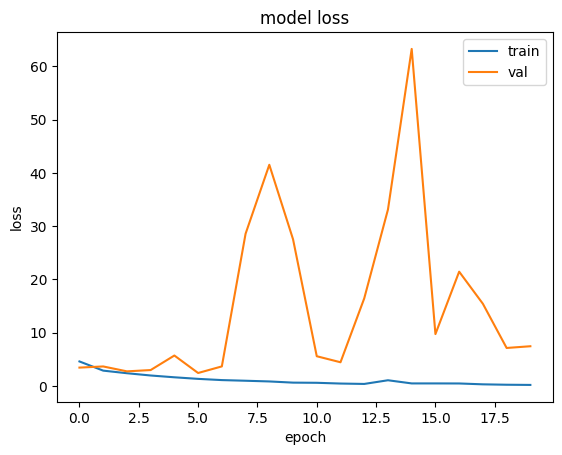

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

In [ ]:
predictions = CNNmodel.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
test_loss, test_accuracy = CNNmodel.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6376 - loss: 9.0983
Test accuracy: 0.6503267884254456


In [ ]:
y_test_flat = np.array(y_test, dtype='int')

y_test_flat = np.argmax(y_test_flat, axis=1)

In [ ]:
# Metrics
accuracy = accuracy_score(y_test_flat, y_pred)
precision = precision_score(y_test_flat, y_pred, average='weighted')
recall = recall_score(y_test_flat, y_pred, average='weighted')
f1 = f1_score(y_test_flat, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.6503
Precision: 0.5513
Recall: 0.6503
F1 Score: 0.5761


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
report = classification_report(y_test_flat, y_pred, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
print(report)

              precision    recall  f1-score   support

        Bach       0.70      0.95      0.81       180
   Beethoven       0.50      0.14      0.22        42
      Chopin       0.00      0.00      0.00        35
      Mozart       0.44      0.45      0.44        49

    accuracy                           0.65       306
   macro avg       0.41      0.39      0.37       306
weighted avg       0.55      0.65      0.58       306



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(y_test_flat, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[171   0   0   9]
 [ 26   6   0  10]
 [ 20   6   0   9]
 [ 27   0   0  22]]


### RNN (LSTM) Training

In [ ]:
# --- LSTM Model for Windowed Input ---
from tensorflow.keras.callbacks import ModelCheckpoint


# Define LSTM model
model_windowed = Sequential()
model_windowed.add(Embedding(len(all_pitches), 128, input_length=window_size))  # Window size as input length
model_windowed.add(LSTM(256, return_sequences=True))
model_windowed.add(Dropout(0.3))
model_windowed.add(LSTM(128))
model_windowed.add(Dropout(0.3))
model_windowed.add(Dense(64, activation='relu'))
model_windowed.add(Dense(4, activation='softmax'))

# Compile the model
model_windowed.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create tf.data.Dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_rnn, y_train_rnn))
train_dataset = train_dataset.batch(512).prefetch(tf.data.AUTOTUNE)

# Create tf.data.Dataset for testing
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_rnn, y_test_rnn))
test_dataset = test_dataset.batch(512).prefetch(tf.data.AUTOTUNE)

# Save model periodically since training takes so long
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/windowed_model.keras',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# Train the model using the dataset
history = model_windowed.fit(train_dataset, epochs=10, validation_data=test_dataset, callbacks=[early_stopping])

# Save the model again  because it takes really long to retrain
model_windowed.save('/content/drive/MyDrive/windowed_model_final.keras')
%cd /content/drive/MyDrive/
model_windowed.save('final_model.keras')

# Evaluate the model
loss, accuracy = model_windowed.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Epoch 1/10
/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 638397184 elements. This may consume a large amount of memory.
  warnings.warn(
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5481s 4s/step - accuracy: 0.6202 - loss: 0.8733 - val_accuracy: 0.8040 - val_loss: 0.4629
Epoch 2/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5431s 4s/step - accuracy: 0.8224 - loss: 0.4261 - val_accuracy: 0.8529 - val_loss: 0.3616
Epoch 3/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5658s 4s/step - accuracy: 0.8665 - loss: 0.3309 - val_accuracy: 0.9049 - val_loss: 0.2471
Epoch 4/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5461s 4s/step - accuracy: 0.9193 - loss: 0.2124 - val_accuracy: 0.9430 - val_loss: 0.1567
Epoch 5/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5309s 4s/step - accuracy: 0.9567 - loss: 0.1211 - val_accuracy: 0.9669 - val_loss: 0.0966
Epoch 6/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5378s 4s/step - accuracy: 0.9736 - loss: 0.0766 - val_accuracy: 0.9774 - val_loss: 0.0674
Epoch 7/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5260s 4s/step - accuracy: 0.9836 - loss: 0.0475 - val_accuracy: 0.9841 - val_loss: 0.0489
Epoch 8/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5269s 4s/step - accuracy: 0.9877 - loss: 0.0359 - val_accuracy: 0.9853 - val_loss: 0.0453
Epoch 9/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5285s 4s/step - accuracy: 0.9902 - loss: 0.0287 - val_accuracy: 0.9891 - val_loss: 0.0348
Epoch 10/10
 945/1502 ━━━━━━━━━━━━━━━━━━━━ 32:16 3s/step - accuracy: 0.9912 - loss: 0.0264

In [ ]:
# Load model from h5 file (if needed)
from tensorflow.keras.models import load_model
# model_windowed = load_model('/content/drive/MyDrive/windowed_model_final.h5')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

In [ ]:
df = pd.DataFrame({
    'loss': training_loss,
    'accuracy': training_accuracy,
    'val_loss': validation_loss,
    'val_accuracy': validation_accuracy
})
df.to_csv('/content/drive/MyDrive/training_history.csv', index=False)

In [ ]:
# Show example predictions, feed in file and output predicted composer with actual composer
predictions = model_windowed.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

for i in range(len(X_test)):
    print(f"Actual: {np.argmax(y_test[i])}, Predicted: {predicted_labels[i]}")

In [ ]:
# Recode numerical labels to composer names
composers = ['Bach', 'Mozart', 'Beethoven', 'Chopin']
y_true = [np.argmax(y_test[i]) for i in range(len(X_test))]
y_pred_names = [composers[pred] for pred in predicted_labels]
y_true_names = [composers[true] for true in y_true]

# Create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_names, y_pred_names, labels=composers)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=composers, yticklabels=composers)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Composer Prediction')
plt.show()